# Linnunradan rotaatio
Tutki tähtien säteis- ja tangentiaalinopeuksia etäisyyden funktiona

Lataa python-modulit

In [1]:
import numpy as np
from numpy import array,append,arange,zeros,exp,sin,random,std
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors

import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.coordinates import Angle

Lataa Gaia-arkiston taulukot 

In [2]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3

tables = Gaia.load_tables(only_names=True)
#for table in (tables):
#    print (table.get_qualified_name())


INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


Määrittele muunnosmatriisi galaktisen ja ekvatoriaalisen koordinaatiston välillä

In [3]:
#T=Rz(90-theta)Rx(90-deltaP)Rz(90+alphaP)
#with angles from Liu et al. A&A 536, A102 (2011)
raGP=Angle('12:51:26.2755 hours')  # R.A. of the North Galactic Pole
decGP=Angle('27:07:41.704 degrees') # Dec. of the NGP 
clonGC=Angle('122.93191857 degrees')          # complement of galactic longitude of the G.Centre
phi=np.pi/2.0-clonGC.radian
psi=np.pi/2.0+raGP.radian
theta=np.pi/2.0-decGP.radian
degr=np.pi/180.0
print('Psi =', psi/degr)
print('theta = ',theta/degr)
print('phi = ',phi/degr)


Rzpsi=[[np.cos(psi),np.sin(psi),0.0],[-np.sin(psi),np.cos(psi),0.0],[0.0,0.0,1.0]]
Rxtheta=[[1.0,0.0,0.0],[0.0,np.cos(theta),np.sin(theta)],[0.0,-np.sin(theta),np.cos(theta)]]
Rzphi=[[np.cos(phi),np.sin(phi),0.0],[-np.sin(phi),np.cos(phi),0.0],[0.0,0.0,1.0]]
TR=np.matmul(Rzphi,np.matmul(Rxtheta,Rzpsi))    
       
print('T=')    
print(TR)   

Psi = 282.85948125
theta =  62.87174888888889
phi =  -32.93191856999999
T=
[[-0.05487554 -0.8734371  -0.48383499]
 [ 0.49410945 -0.44482959  0.74698225]
 [-0.86766614 -0.19807639  0.45598379]]


Valitse suunta Linnunradan tasossa ja laske sen ekvatoriaaliset koordinaatit

In [4]:
degr=np.pi/180.0
l0=45.0*degr
b0=0.0
d0=1.0
BigXYZ=d0*array([[np.cos(l0)*np.cos(b0)],[np.sin(l0)*np.cos(b0)],[np.sin(b0)]])
xyz=np.matmul(np.transpose(TR),BigXYZ)
ra=np.arctan(xyz[1]/xyz[0])
dec=np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
#print(ra)
if ra[0]<0.0:
    ra[0]=ra[0]+2.0*np.pi
    
degr=np.pi/180.0
ra1=Angle('%s degrees' % str(ra[0]/degr))
dec1=Angle('%s degrees' % str(dec[0]/degr))
#print(ra1.degree,dec1.degree)
print('ra    ',"%.4f" % ra1.degree, 'degr')
print('dec',"%.4f" % dec1.degree, 'degr')
print(ra1.hms)
print(dec1.dms)

ra     288.4276 degr
dec 10.7237 degr
hms_tuple(h=19.0, m=13.0, s=42.619711987947255)
dms_tuple(d=10.0, m=43.0, s=25.353480952516065)


Hae tähdet 1 asteen säteellä tästä suunnasta minimietäisyydellä 1 kpc.

In [5]:
job0 = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaia_source.ra,gaia_source.dec),\
CIRCLE('ICRS', 288.4276, 10.7237,1.0))=1 \
AND visibility_periods_used >=5 \
AND (parallax)<1.0 \
AND parallax_over_error > 3.0 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND RUWE < 1.6 \
AND radial_velocity IS NOT NULL;",dump_to_file=False)
#AND astrometric_excess_noise<=1;", dump_to_file=False)

INFO: Query finished. [astroquery.utils.tap.core]


Anna otokselle nimi "r". Tutki sen kokoa. 

In [6]:
r = job0.get_results()
print (r['parallax', 'parallax_over_error','pmra','radial_velocity'])

      parallax      parallax_over_error         pmra         radial_velocity
        mas                                   mas / yr            km / s    
------------------- ------------------- -------------------- ---------------
 0.2510168084107293            8.556358   -3.105412897369028       18.716684
0.41670134924152885            18.73903  -2.2219829565704243      -5.5365105
 0.9049111255278071           31.752174  -5.6482488056987945      -24.482212
0.21642967946310637            6.358638  -2.0933066040606887       41.239113
0.18216697951260535           5.7763233  -1.1467813189366007        73.43707
0.33155962293515895            9.565925   -1.323373072574823       12.834667
                ...                 ...                  ...             ...
 0.6093331199182882           5.7275605   -2.770430239449461        38.77863
 0.4769986927491934           13.407604   -7.839812453889479       5.1875677
 0.3631681879390601            6.555364  -2.1050067866735445        42.01058

Määrittele tähtien ekvatoriaaliset paikka- ja nopeuskoordinaatit.

In [7]:
distance=1.0/(r['parallax'].data)
ra=(r['ra'].data)*degr
print(type(ra))
dec=(r['dec'].data)*degr
print(type(dec))
vrad=r['radial_velocity'].data
talpha=4.74*r['pmra'].data*distance
tdelta=4.74*r['pmdec'].data*distance
#print(vrad)
#print(talpha)
#print(tdelta)
vequatorial=array([[vrad],[talpha],[tdelta]]).reshape(3,len(distance))

#print(vequatorial)
#print(type(vequatorial))

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
[[ 18.71668434  -5.53651047 -24.48221207 ...  69.82732391  27.48911858
   22.67115402]
 [-58.64012544 -25.27517425 -29.58599865 ... -29.92157565   5.12506072
   -5.18449627]
 [-72.97299023 -70.25811683 -43.3197402  ... -83.22070294 -21.58900988
  -46.67253575]]
<class 'numpy.ndarray'>


Laske teoreettiset säteis- ja tangentiaalinopeudet olettaen, että kiertonopeus $\Theta(R)$ on vakio ($=\Theta_0$). Käytä arvoja $R_0=8.1$ kpc ja $\Theta_0=230$ km/s. 

In [8]:
theta0=230.0
R0=8.1
dvector=arange(0,10)
Rvector=R0*np.sqrt(1.0+(dvector/R0)**2-2.0*(dvector/R0)*np.cos(l0))
vrvector=theta0*(R0/Rvector-1.0)*np.sin(l0)
vtvector=theta0*((R0/Rvector-1.0)*np.cos(l0)-dvector/Rvector)

#plt.plot(x,y1, color='b')
#plt.plot(x,y2, color='b')


Otetaan huomioon Auringon pekuliaarinopeus LSR:n suhteen: U_a ~ 10 km/s, V_a ~ 15 km/s. Suunnassa $l=45^\circ$ näiden vaikutus on v_r,a = (U_a + V_a) cos (45) ~ 17.7 km/s, v_t,a = (V_a -U_a) sin(45) ~ 3.5 km/s.  Määritellään Auringon liikkellä korjatut teoreettiset nopeuskäyrät. 

In [17]:

vrsun=17.7
vtsun=3.5
vrcorvector=vrvector-vrsun
vtcorvector=vtvector-vtsun


Plottaa tähtien säteisnopeus etäisyyden funktiona. Piirrä samaan kuvan yllä laskettu teoreettinen käyrä ja Auringon pekuliaariliikkeellä korjattu käyrä.  

(-150.0, 150.0)

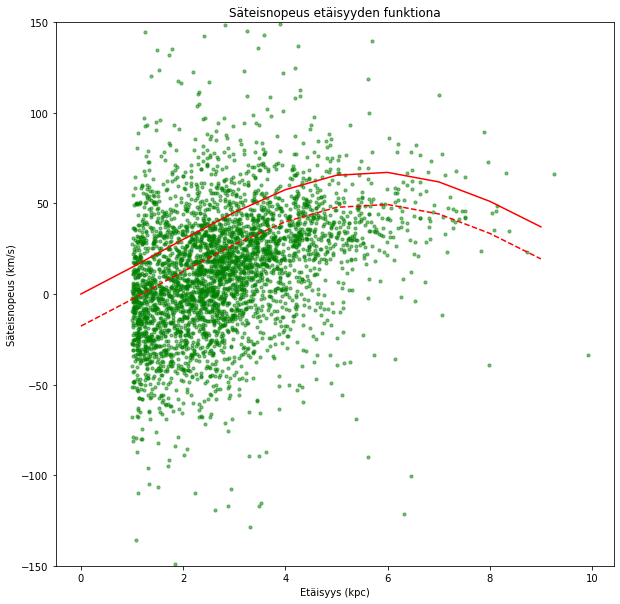

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
#ax = plt.gca()
#ax.set_aspect(1.0)
ax.scatter(distance, vrad, alpha=0.5, s=10, color='g', zorder=0)
plt.plot(dvector,vrvector,color='r')
plt.plot(dvector,vrcorvector,color='r',linestyle='dashed')
#plt.xlim(-5,15)
plt.title('Säteisnopeus etäisyyden funktiona')
plt.xlabel('Etäisyys (kpc)')
plt.ylabel('Säteisnopeus (km/s)')
plt.ylim(-150,150)

Määrittele muunnosmatriisi heliosentristen $({\dot x},{\dot y},{\dot z})$-koordinaatttien laskemiseksi

In [21]:
Rydelta=zeros((3,3,len(distance)))

for i in range(len(distance)):
         Rydelta[:,:,i]=[[np.cos(dec[i]),0.0,-np.sin(dec[i])],
                         [0.0,1.0,0.0],
                        [np.sin(dec[i]),0.0,np.cos(dec[i])]]
  

Rzalpha=zeros((3,3,len(distance)))

for i in range(len(distance)):
         Rzalpha[:,:,i]=[[np.cos(ra[i]),-np.sin(ra[i]),0.0],
                        [np.sin(ra[i]),np.cos(ra[i]),0.0],
                        [0.0,0.0,1.0]]


Rottoxyz=zeros((3,3,len(distance)))

for i in range(len(distance)):
         Rottoxyz[:,:,i]=np.matmul(Rzalpha[:,:,i],Rydelta[:,:,i])
        
print(type(Rottoxyz))

<class 'numpy.ndarray'>


Muunna nopeudet $(v_r,t_\alpha,t_\delta)$ nopeuksiksi $({\dot x},{\dot y},{\dot z})$.

In [22]:
xyzdots=zeros((3,len(distance)))
for i in range(len(distance)):
         xyzdots[:,i]=np.matmul(Rottoxyz[:,:,i],vequatorial[:,i])
        
print(type(xyzdots))
print(xyzdots.shape)

<class 'numpy.ndarray'>
(3, 3807)


Laske heliosentriset koordinaatit $(x,y,z)$ koordinateista $(d,\alpha,\delta)$. 

In [23]:
#print(dec)
d=zeros((len(distance)))
for i in range(len(distance)):
    d[i]=distance[i]
    
xyzs=d*array([[np.cos(ra)*np.cos(dec)],
                    [np.sin(ra)*np.cos(dec)],
                    [np.sin(dec)]]).reshape(3,len(distance))


#requatorial=array(distance)
print(type(xyzs))
print(xyzs.shape)
print(xyzs)


<class 'numpy.ndarray'>
(3, 3807)
[[ 1.17816496  0.71038232  0.32562383 ...  0.90140474  1.21773216
   1.17309513]
 [-3.73362689 -2.24886378 -1.03616592 ... -2.62268046 -3.55054342
  -3.41965753]
 [ 0.73661105  0.44385793  0.20379671 ...  0.56613572  0.76576691
   0.73773519]]


Laske $(X,Y,Z)$-koordinaatit ja $(U,V,W)$-nopeudet koordinateista $(x,y,z)$ ja 
$({\dot x},{\dot y},{\dot z})$ 

In [24]:
print(type(TR))
print(TR.shape)
print(type(xyzs))
print(xyzs.shape)

BigXYZ=np.matmul(TR,xyzs)
print(type(BigXYZ))
print(BigXYZ.shape)

BigUVW=np.matmul(TR,xyzdots)
print(type(BigUVW))
print(BigUVW.shape)

<class 'numpy.ndarray'>
(3, 3)
<class 'numpy.ndarray'>
(3, 3807)
<class 'numpy.ndarray'>
(3, 3807)
<class 'numpy.ndarray'>
(3, 3807)


Laske tähtien tangentiaaliset nopeuskomponentit

In [25]:
glon=(r['l'].data)*degr

gallon=zeros((len(distance)))
for i in range(len(distance)):
    gallon[i]=glon[i]

vtan=BigUVW[1,:]*np.cos(gallon)-BigUVW[0,:]*np.sin(gallon)

print(type(vtan))
print(vtan.shape)


<class 'numpy.ndarray'>
(3807,)


Plottaa tangentiaaliset nopeudet etäisyyden funktiona. Piirrä samaan kuvaan teoreettiset käyrät. 

(-300.0, 50.0)

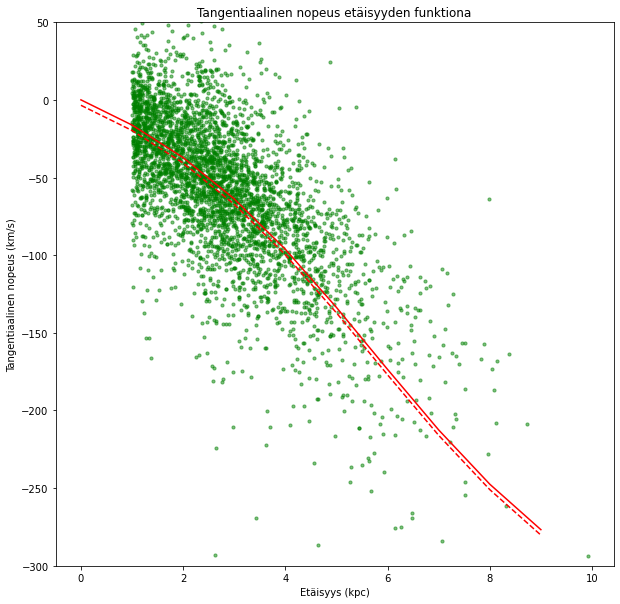

In [26]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
#ax = plt.gca()
#ax.set_aspect(1.0)
ax.scatter(distance, vtan, alpha=0.5, s=10, color='g', zorder=0)
plt.plot(dvector,vtvector,color='r')
plt.plot(dvector,vtcorvector,color='r', linestyle='dashed')
plt.title('Tangentiaalinen nopeus etäisyyden funktiona')
plt.xlabel('Etäisyys (kpc)')
plt.ylabel('Tangentiaalinen nopeus (km/s)')

#plt.xlim(-5,15)
plt.ylim(-300,50)

Oletus $\Theta = \Theta_0$ sopii melko hyvin suunnassa $l=45^\circ$ havaittuihin tähtien säteis- ja tangentiaalinopeuksiin usean kpc päähän. Säteisnopeuksissa Auringon pekuliaarinopeudesta johtuva korjaus on huomattava.  